In [2]:
from easydict import EasyDict as edict
# 字典访问，用来存储超参数
import os
# os模块主要用于处理文件和目录
import numpy as np
# 科学计算库
import matplotlib.pyplot as plt
# 绘图库

import mindspore
# MindSpore库
import mindspore.dataset as ds
# 数据集处理模块
from mindspore.dataset.vision import c_transforms as vision
# 图像增强模块
from mindspore import context
# 环境设置模块
import mindspore.nn as nn
# 神经网络模块
from mindspore.train import Model
# 模型编译
from mindspore.nn.optim.momentum import Momentum
# 动量优化器
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
# 模型保存设置
from mindspore import Tensor
# 张量
from mindspore.train.serialization import export
# 模型导出
from mindspore.train.loss_scale_manager import FixedLossScaleManager
# 损失值平滑处理
from mindspore.train.serialization import load_checkpoint, load_param_into_net
# 模型加载
import mindspore.ops as ops
# 常见算子操作

# 设置MindSpore的执行模式和设备
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

In [4]:
cfg = edict({
    'data_path': './data/flower_photos_train',   #训练数据集路径
    'test_path':'./data/flower_photos_train',     #测试数据集路径
    'data_size': 3616,
    'HEIGHT': 224,  # 图片高度
    'WIDTH': 224,  # 图片宽度
    '_R_MEAN': 123.68, # CIFAR10的均值
    '_G_MEAN': 116.78,
    '_B_MEAN': 103.94,
    '_R_STD': 1, # 自定义的标准差
    '_G_STD': 1,
    '_B_STD':1,
    '_RESIZE_SIDE_MIN': 256, # 图像增强resize最小值
    '_RESIZE_SIDE_MAX': 512,
    
    'batch_size': 32, # 批次大小
    'num_class': 5,     # 分类类别
    'epoch_size': 5,  # 训练次数
    'loss_scale_num':1024,
    
    'prefix': 'resnet-ai',  # 模型保存的名称
    'directory': './model_resnet',  # 模型保存的路径
    'save_checkpoint_steps': 10, # 每隔10步保存ckpt
})

[WARNING] ME(3876:17068,MainProcess):2023-07-17-09:17:07.682.29 [mindspore\dataset\core\validator_helpers.py:806] 'Decode' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Decode' from mindspore.dataset.vision instead.
[WARNING] ME(3876:17068,MainProcess):2023-07-17-09:17:07.692.29 [mindspore\dataset\core\validator_helpers.py:806] 'Normalize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Normalize' from mindspore.dataset.vision instead.
[WARNING] ME(3876:17068,MainProcess):2023-07-17-09:17:07.703.87 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(3876:17068,MainProcess):2023-07-17-09:17:07.708.94 [mindspore\dataset\core\validator_helpers.py:806] 'CenterCro

训练数据集数量： 480
测试数据集数量： 500
通道数/图像长/宽： (3, 224, 224)
一张图像的标签样式： 2


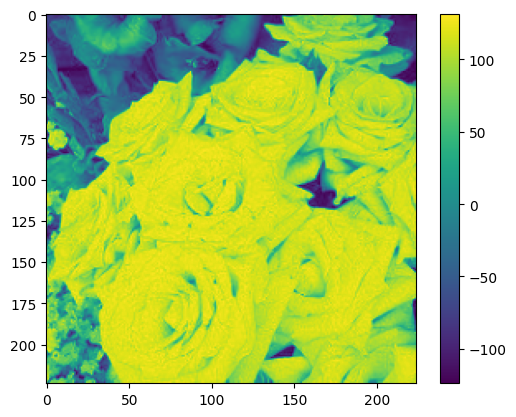

In [5]:
# 数据处理
def read_data(path,config,usage="train"):
    # 从目录中读取图像的源数据集。
    dataset = ds.ImageFolderDataset(path,
                                   class_indexing={'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4})
    # define map operations
    # 图像解码算子
    decode_op = vision.Decode() 
    # 图像正则化算子
    normalize_op = vision.Normalize(mean=[cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN], std=[cfg._R_STD, cfg._G_STD, cfg._B_STD])
    # 图像调整大小算子
    resize_op = vision.Resize(cfg._RESIZE_SIDE_MIN)
    # 图像裁剪算子
    center_crop_op = vision.CenterCrop((cfg.HEIGHT, cfg.WIDTH))
    # 图像随机水平翻转算子
    horizontal_flip_op = vision.RandomHorizontalFlip()
    # 图像通道数转换算子
    channelswap_op = vision.HWC2CHW()
    # 图像随机裁剪解码编码调整大小算子
    random_crop_decode_resize_op = vision.RandomCropDecodeResize((cfg.HEIGHT, cfg.WIDTH), (0.5, 1.0), (1.0, 1.0), max_attempts=100)

    # 只对训练集做的预处理操作
    if usage == 'train':
        dataset = dataset.map(input_columns="image", operations=random_crop_decode_resize_op)
        dataset = dataset.map(input_columns="image", operations=horizontal_flip_op)
    # 只对测试集做的预处理操作
    else:
        dataset = dataset.map(input_columns="image", operations=decode_op)
        dataset = dataset.map(input_columns="image", operations=resize_op)
        dataset = dataset.map(input_columns="image", operations=center_crop_op)
    
    # 对全部数据集做的预处理操作
    dataset = dataset.map(input_columns="image", operations=normalize_op)
    dataset = dataset.map(input_columns="image", operations=channelswap_op)

    # 对训练集做的批次处理
    if usage == 'train':
        dataset = dataset.shuffle(buffer_size=10000)  # 10000 as in imageNet train script
        dataset = dataset.batch(cfg.batch_size, drop_remainder=True)
    # 对测试集做的批次处理
    else:
        dataset = dataset.batch(1, drop_remainder=True)
    
    # 数据增强
    dataset = dataset.repeat(1)
    
    dataset.map_model = 4

    return dataset

# 查看训练集和测试集的数量
de_train = read_data(cfg.data_path,cfg,usage="train")
de_test = read_data(cfg.test_path,cfg,usage="test")
print('训练数据集数量：',de_train.get_dataset_size()*cfg.batch_size) # get_dataset_size()获取批处理的大小。
print('测试数据集数量：',de_test.get_dataset_size())

# 查看训练集的样图
data_next = de_train.create_dict_iterator(output_numpy=True).__next__()
print('通道数/图像长/宽：', data_next['image'][0,...].shape)
print('一张图像的标签样式：', data_next['label'][0])  # 一共5类，用0-4的数字表达类别。

plt.figure()
plt.imshow(data_next['image'][0,0,...])
plt.colorbar()
plt.grid(False)
plt.show() 

ResNet50是一种常用的深度神经网络模型，主要用于图像分类。它由一系列的残差块（Residual Block）组成，每个残差块包含三个卷积层（Convolutional Layer）和相应的批量归一化（Batch Normalization）层。

具体来说，代码中定义了以下几个部分：

- `_weight_variable`：定义了权重初始化的函数，权重的初始值由正态分布生成。
- `_conv1x1`, `_conv3x3`, `_conv7x7`：定义了1x1、3x3和7x7的卷积层，分别用于进行通道数的变换、提取特征和减小特征图的尺寸。
- `_bn`, `_bn_last`：定义了批量归一化层，用于加速训练过程和提高模型性能。
- `_fc`：定义了全连接层，用于最后的分类任务。
- `ResidualBlock`：定义了残差块，每个残差块包含三个卷积层（1x1、3x3和1x1的卷积）和相应的批量归一化层，以及一个恒等映射（Identity Mapping），如果需要的话，还会包含一个下采样层（Downsampling Layer）。
- `ResNet`：定义了整个ResNet网络，包含一个7x7的卷积层、一个最大池化层（Max Pooling Layer），四个残差层（每个残差层由多个残差块组成），以及一个全连接层。
- `resnet50`：一个方便创建ResNet50实例的函数。

在每个残差块中，第一个卷积层和第二个卷积层用于提取特征，第三个卷积层用于增加通道数以便与恒等映射进行相加。每个卷积层后都会跟着一个批量归一化层，用于进行特征的标准化。在所有卷积层和批量归一化层后都会有一个ReLU激活函数，用于增加模型的非线性。在每个残差块的最后，会将最后的卷积层的输出与恒等映射进行相加，这就是残差连接的主要思想。

在ResNet网络中，首先通过一个7x7的卷积层和一个最大池化层对输入图像进行初步的特征提取和尺寸缩小，然后通过四个残差层进行深层的特征提取，最后通过一个全连接层进行分类。四个残差层中的每个残差层都由多个残差块组成，每个残差层的第一个残差块的卷积层的步长（Stride）都为2，用于减小特征图的尺寸，其它的残差块的卷积层的步长都为1。

In [6]:
"""ResNet."""

# 定义权重初始化函数
def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)

# 定义3X3卷积函数
def _conv3x3(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 3, 3)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=3, stride=stride, padding=0, pad_mode='same', weight_init=weight)

# 定义1X1卷积层函数
def _conv1x1(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=weight)

# 定义7X7卷积层函数
def _conv7x7(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)

# 定义Batch Norm层函数
def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)

# 定义最后一层的Batch Norm函数
def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)

# 定义全连接层函数
def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = _weight_variable(weight_shape)
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)

# 构建残差模块
class ResidualBlock(nn.Cell):
    """
    ResNet V1 residual block definition.

    Args:
        in_channel (int): Input channel.
        out_channel (int): Output channel.
        stride (int): Stride size for the first convolutional layer. Default: 1.

    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResidualBlock(3, 256, stride=2)
    """
    expansion = 4  # conv2_x--conv5_x中，前两层的卷积核的个数是第三层（也就是输出通道）的4分之一。

    def __init__(self, in_channel, out_channel, stride=1):
        super(ResidualBlock, self).__init__()

        # 前两层的卷积核个数等于输出通道的四分之一
        channel = out_channel // self.expansion  
        
        # 第一层卷积
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)
        # 第二层卷积
        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)
        
        # 第三层卷积，其中卷积核个数等于输出通道
        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn_last(out_channel)
        
        # Relu激活层
        self.relu = nn.ReLU()

        self.down_sample = False
        
        # 当步长不为1、或输出通道不等于输入通道时，进行图像下采样，用来调整通道数
        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None
        # 用1X1卷积调整通道数
        if self.down_sample:
            self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride), # 1X1卷积
                                                        _bn(out_channel)])  # Batch Norm
        # 加法算子
        self.add = ops.Add()

    # 构建残差块    
    def construct(self, x): 
        # 输入
        identity = x
        
        # 第一层卷积 1X1
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # 第二层卷积 3X3
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        # 第三层卷积 1X1
        out = self.conv3(out)
        out = self.bn3(out)

        # 改变网络的维度
        if self.down_sample:
            identity = self.down_sample_layer(identity)
        
        # 加上残差
        out = self.add(out, identity)
        # Relu激活
        out = self.relu(out)

        return out

# 构建残差网络
class ResNet(nn.Cell):
    """
    ResNet architecture.

    Args:
        block (Cell): Block for network.
        layer_nums (list): Numbers of block in different layers.
        in_channels (list): Input channel in each layer.
        out_channels (list): Output channel in each layer.
        strides (list):  Stride size in each layer.
        num_classes (int): The number of classes that the training images are belonging to.
    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResNet(ResidualBlock,
        >>>        [3, 4, 6, 3],
        >>>        [64, 256, 512, 1024],
        >>>        [256, 512, 1024, 2048],
        >>>        [1, 2, 2, 2],
        >>>        10)
    """

    # 输入参数为：残差块，残差块重复数，输入通道，输出通道，步长，图像类别数
    def __init__(self, block, layer_nums, in_channels, out_channels, strides, num_classes):
        super(ResNet, self).__init__()
        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")

        # 第一层卷积，卷积核7X7，输入通道3，输出通道64，步长2
        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = ops.ReLU()
        
        # 3X3池化层，步长2
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        # conv2_x残差块
        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=strides[0])
        # conv3_x残差块
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=strides[1])
        # conv4_x残差块
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=strides[2])
        # conv5_x残差块
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=strides[3])
        # 均值算子
        self.mean = ops.ReduceMean(keep_dims=True)
        # Flatten层
        self.flatten = nn.Flatten()
        # 输出层
        self.end_point = _fc(out_channels[3], num_classes)

    # 输入参数为：残差块，残差块重复数，输入通道，输出通道，步长
    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        """
        Make stage network of ResNet.

        Args:
            block (Cell): Resnet block.
            layer_num (int): Layer number.
            in_channel (int): Input channel.
            out_channel (int): Output channel.
            stride (int): Stride size for the first convolutional layer.

        Returns:
            SequentialCell, the output layer.

        Examples:
            >>> _make_layer(ResidualBlock, 3, 128, 256, 2)
        """
        # 搭建convn_x的残差块
        
        layers = []
        
        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)

        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)

        return nn.SequentialCell(layers)
    
    # 构建 ResNet网络
    def construct(self, x): 
        x = self.conv1(x)  # 第一层卷积7X7，步长为2
        x = self.bn1(x)    # 第一层的Batch Norm
        x = self.relu(x)   # Rule激活层
        c1 = self.maxpool(x)  # 最大池化3X3，步长为2

        c2 = self.layer1(c1) # conv2_x残差块
        c3 = self.layer2(c2) # conv3_x残差块
        c4 = self.layer3(c3) # conv4_x残差块
        c5 = self.layer4(c4) # conv5_x残差块

        out = self.mean(c5, (2, 3)) # 平均池化层
        out = self.flatten(out)  # Flatten层
        out = self.end_point(out)  # 输出层

        return out

# 构建ResNet50 网络
def resnet50(class_num=5):
    """
    Get ResNet50 neural network.

    Args:
        class_num (int): Class number.

    Returns:
        Cell, cell instance of ResNet50 neural network.

    Examples:
        >>> net = resnet50(10)
    """
    return ResNet(ResidualBlock,    # 残差块
                  [3, 4, 6, 3],  # 残差块数量
                  [64, 256, 512, 1024],  # 输入通道
                  [256, 512, 1024, 2048], # 输出通道
                  [1, 2, 2, 2],  # 步长
                  class_num) # 输出类别数

In [7]:
# 构建ResNet50网络，输出类别数为5，对应5种花的类别
net=resnet50(class_num=cfg.num_class)

#读取预训练模型参数
param_dict = load_checkpoint("./data/resnet50_ascend_v170_imagenet2012_official_cv_top1acc76.97_top5acc93.44.ckpt")

#展示读取的模型参数
print(param_dict)

#通过mindspore.Parameter（）修改end_point.weight和end_point.bias对应的shape
param_dict["end_point.weight"] = mindspore.Parameter(Tensor(param_dict["end_point.weight"][:5, :], mindspore.float32), name="variable")
param_dict["end_point.bias"]= mindspore.Parameter(Tensor(param_dict["end_point.bias"][:5,], mindspore.float32), name="variable")

# 设置Softmax交叉熵损失函数
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

# 设置学习率
train_step_size = de_train.get_dataset_size()
lr = nn.cosine_decay_lr(min_lr=0.0001, max_lr=0.001, total_step=train_step_size * cfg.epoch_size,step_per_epoch=train_step_size, decay_epoch=cfg.epoch_size)

# 设置动量优化器
opt = Momentum(net.trainable_params(), lr, momentum=0.9, weight_decay=1e-4, loss_scale=cfg.loss_scale_num)

# 损失值平滑，解决训练过程中梯度过小的问题
loss_scale = FixedLossScaleManager(cfg.loss_scale_num, False)

# 模型编译，输入网络结构，损失函数，优化器，损失值平滑，以及模型评估标准
model = Model(net, loss_fn=loss, optimizer=opt, loss_scale_manager=loss_scale, metrics={'acc'})

# 损失值监控
loss_cb = LossMonitor(per_print_times=train_step_size)

# 模型保存参数，设置每隔多少步保存一次模型，最多保存几个模型
ckpt_config = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps, keep_checkpoint_max=1)

# 模型保存，设置模型保存的名称，路径，以及保存参数
ckpoint_cb = ModelCheckpoint(prefix=cfg.prefix, directory=cfg.directory, config=ckpt_config)

print("============== Starting Training ==============")
# 训练模型，设置训练次数，训练集，回调函数，是否采用数据下沉模式（只可应用于Ascend 和GPU，可加快训练速度）
model.train(cfg.epoch_size, de_train, callbacks=[loss_cb,ckpoint_cb], dataset_sink_mode=True)
# 训练时长大约15-20分钟

# 使用测试集进行模型评估，输出测试集的准确率
metric = model.eval(de_test)
print(metric) 


{'conv1.weight': Parameter (name=conv1.weight, shape=(64, 3, 7, 7), dtype=Float32, requires_grad=True), 'bn1.gamma': Parameter (name=bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'bn1.beta': Parameter (name=bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv1.weight': Parameter (name=layer1.0.conv1.weight, shape=(64, 64, 1, 1), dtype=Float32, requires_grad=True), 'layer1.0.bn1.gamma': Parameter (name=layer1.0.bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.bn1.beta': Parameter (name=layer1.0.bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv2.weight': Parameter (name=layer1.0.conv2.weight, shape=(64, 64, 3, 3), dtype=Float32, requires_grad=True), 'layer1.0.bn2.gamma': Parameter (name=layer1.0.bn2.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.bn2.beta': Parameter (name=layer1.0.bn2.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv3.weight': Parameter (name=layer1.0.co

epoch: 1 step: 15, loss is 1.109876275062561
epoch: 2 step: 15, loss is 1.1226129531860352
epoch: 3 step: 15, loss is 1.378843903541565
epoch: 4 step: 15, loss is 0.8598828911781311
epoch: 5 step: 15, loss is 0.9125197529792786
{'acc': 0.628}


In [10]:
# 模型预测，从测试集中取10个样本进行测试，输出预测结果和真实结果
class_names = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}
for i in range(10):
    test_ = de_test.create_dict_iterator().__next__()
    test = Tensor(test_['image'], mindspore.float32)
    # 模型预测
    predictions = model.predict(test)
    predictions = predictions.asnumpy()
    true_label = test_['label'].asnumpy()
    # 显示预测结果
    p_np = predictions[0, :]
    pre_label = np.argmax(p_np)
    print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '   真实结果：', class_names[true_label[0]])

第0个sample预测结果： sunflowers    真实结果： sunflowers
第1个sample预测结果： dandelion    真实结果： dandelion
第2个sample预测结果： roses    真实结果： roses
第3个sample预测结果： dandelion    真实结果： dandelion
第4个sample预测结果： daisy    真实结果： daisy
第5个sample预测结果： roses    真实结果： roses
第6个sample预测结果： sunflowers    真实结果： sunflowers
第7个sample预测结果： roses    真实结果： roses
第8个sample预测结果： dandelion    真实结果： dandelion
第9个sample预测结果： roses    真实结果： dandelion
